# Workflow Model 1

## Import dataset

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alessiocorrado99/animals10")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/animals10


In [3]:

DATASET_URI="/kaggle/input/animals10/raw-img"


In [3]:
# from dotenv import dotenv_values
# from dotenv import dotenv_values

# Retrieve dotenv config
# config = dotenv_values(".env")

# Retrieve DATASET_URI
# DATASET_URI=config["DATASET_URI"]

## Pre-processing

### Imports

In [4]:
import matplotlib.pyplot as plt
import random
import numpy as np
import tensorflow as tf
import keras

# from keras.layers import Dense, Conv2D, Input, Flatten, Dropout, MaxPooling2D, Rescaling
# from keras.models import Sequential
from tensorflow.keras import layers
from tensorflow import data as tf_data


### Data conversion

Define parameters

In [5]:
# Define the parameters.

random.seed(1337)
batch_size = 128 # TODO : increase batch size
image_size = (180, 180)
seed = random.randint(1, 200)

In [26]:

train_ds, val_ds = keras.utils.image_dataset_from_directory(
  directory=DATASET_URI,
  validation_split=0.1, # TODO : 0.1
  subset="both",
  seed=seed,
  image_size=image_size,
  batch_size=batch_size,
)

test_ds = keras.utils.image_dataset_from_directory(
  directory=DATASET_URI,
  validation_split=0.1,
  subset="validation",
  seed=seed,
  image_size=image_size,
  batch_size=batch_size
)

# We print the class names for double check.

print(f"Training classes => {train_ds.class_names}")
print(f"val classes => {val_ds.class_names}")
print(f"Testing classes => {test_ds.class_names}")


Found 26179 files belonging to 10 classes.
Using 23562 files for training.
Using 2617 files for validation.
Found 26179 files belonging to 10 classes.
Using 2617 files for validation.
Training classes => ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
val classes => ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Testing classes => ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


10

### Data visualisation

#### Shape

The results below tell us that :

- The image_batch is a tensor of the shape (32, 180, 180, 3).
- This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB).
- The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

In [7]:
# Print the shapes of the training and the testing dataset
for image_batch, labels_batch in train_ds:
    print(f"Shape of the training set images => {image_batch.shape}")
    print(f"Shape of the training set labels => {labels_batch.shape}")
    break

for image_batch, labels_batch in test_ds:
    print(f"Shape of the testing set images => {image_batch.shape}")
    print(f"Shape of the testing set labels => {labels_batch.shape}")
    break

Shape of the training set images => (128, 180, 180, 3)
Shape of the training set labels => (128,)
Shape of the testing set images => (128, 180, 180, 3)
Shape of the testing set labels => (128,)


#### Pre-visualization

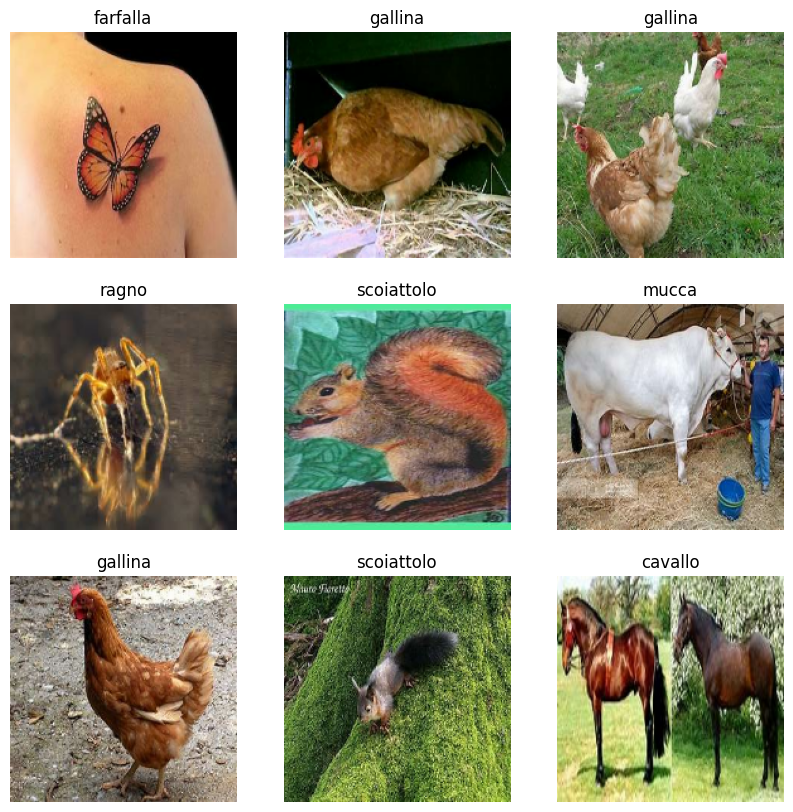

In [8]:
# Print a summary of the image classes with an image of each class.
# We will extract 1 image of the training set.

plt.figure(figsize=(10, 10))
class_names = train_ds.class_names
for images, labels in train_ds.take(1):
  for i in range(len(class_names) - 1):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Model training

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
Dataset.prefetch overlaps data preprocessing and model execution while training.
Interested readers can learn more about both methods, as well as how to cache data to disk in the Prefetching section of the Better performance with the tf.data API guide.

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

- Because we are working with images, the images are in the [0, 255] range.
- We therefore want to normalize the data to values from [0, 1].
- That way, the model will be more pertinent.


 1. Augmentació de dades

Finalitat: augmentar la diversitat del teu dataset de manera artificial per evitar overfitting.
Comentari: Potser podries afegir també RandomZoom, RandomTranslation o RandomContrast si vols més variabilitat.

In [11]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

In [12]:
def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

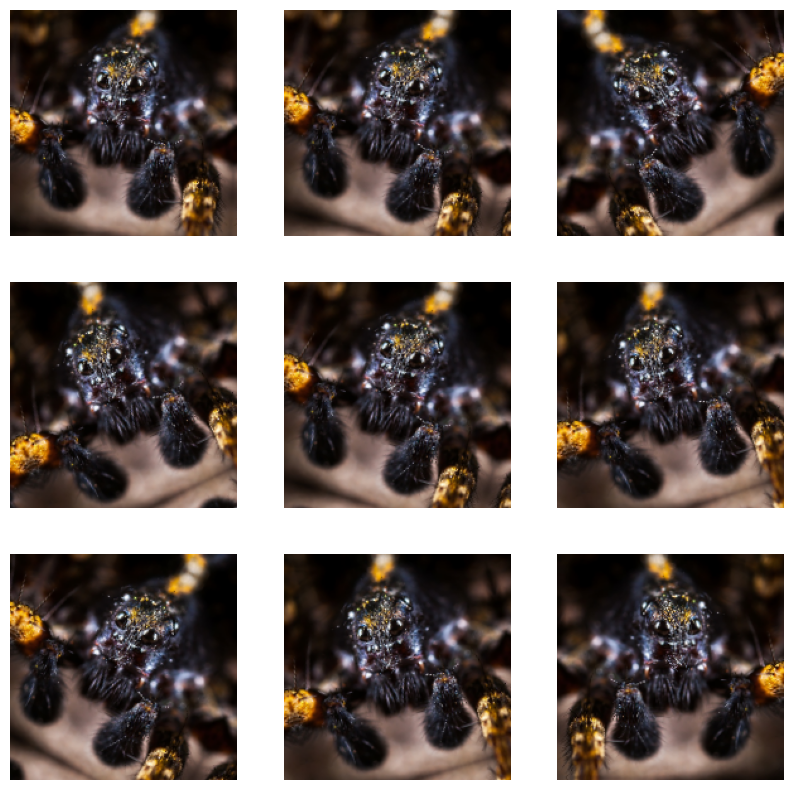

In [13]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")


Apply data augmentation only to train_ds

In [37]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)

In [36]:
AUTOTUNE = tf.data.AUTOTUNE
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.cache().prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

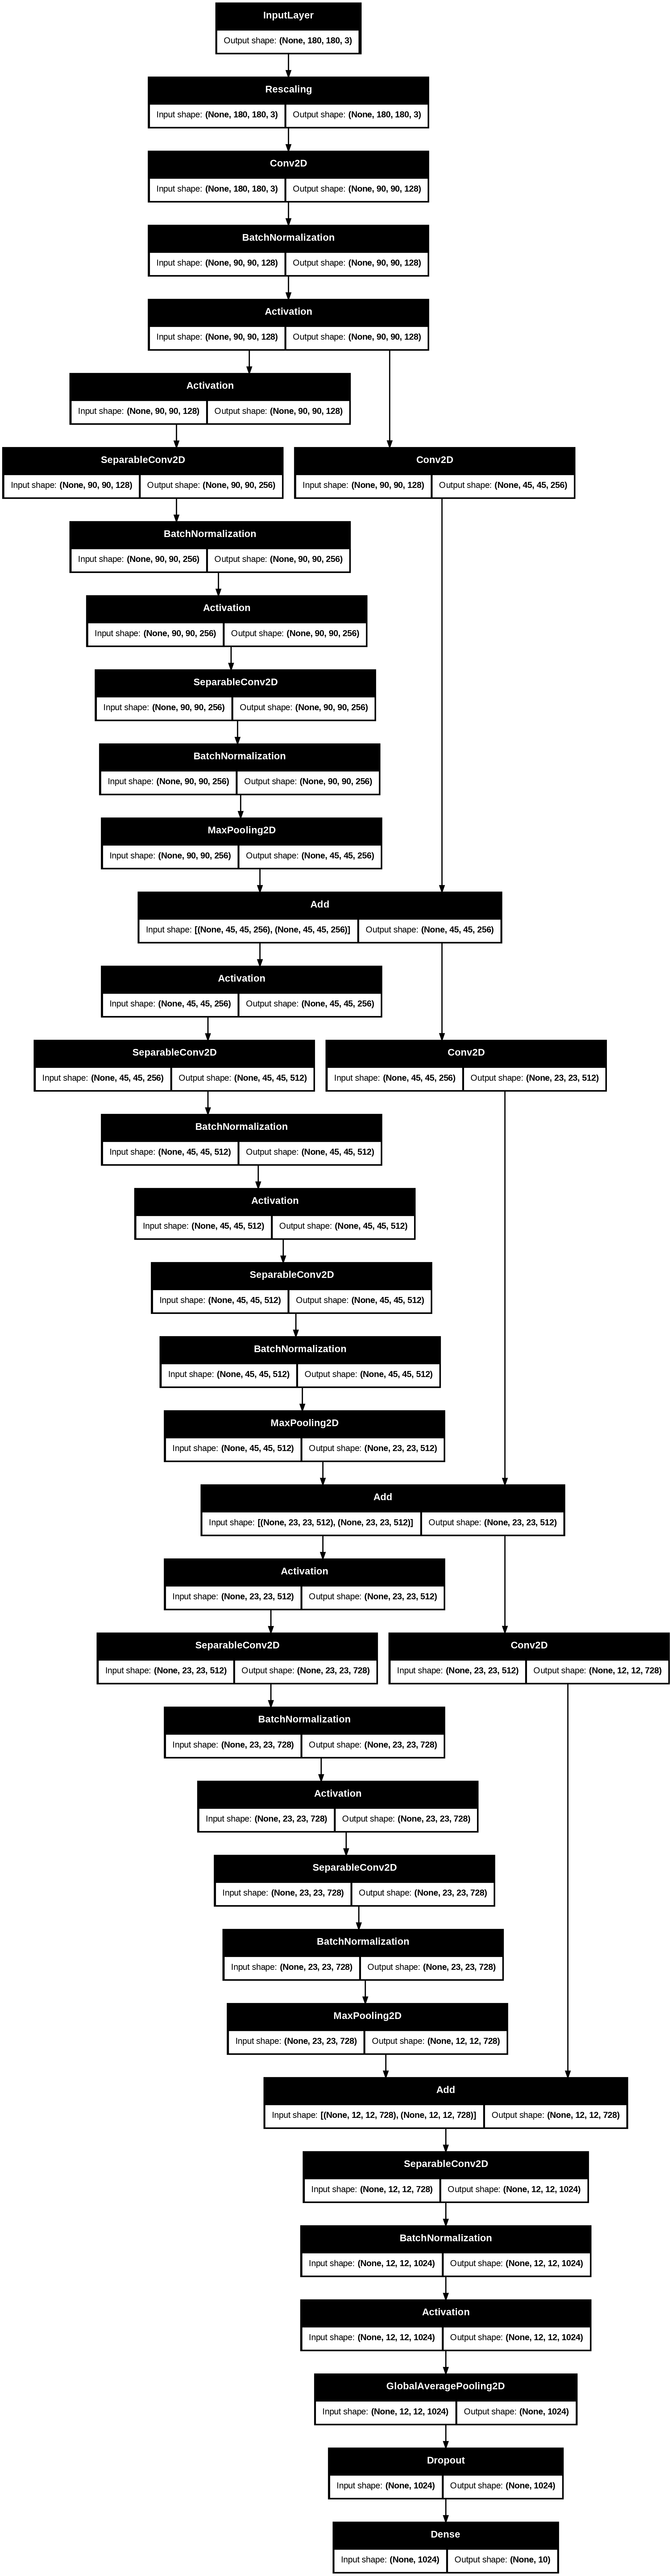

In [47]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)


        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])
        previous_block_activation = x

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)

    units = num_classes

    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model_1 = make_model(input_shape=image_size + (3,), num_classes=10)
keras.utils.plot_model(model_1, show_shapes=True)


In [34]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 180, 180,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 90, 90,    │      3,584 │ rescaling_2[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 90, 90,    │        512 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 90, 90,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 90, 90,    │          0 │ activation_16[0]… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_14 │ (None, 90, 90,    │     34,176 │ activation_17[0]… │
│ (SeparableConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 90, 90,    │      1,024 │ separable_conv2d… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 90, 90,    │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_15 │ (None, 90, 90,    │     68,096 │ activation_18[0]… │
│ (SeparableConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 90, 90,    │      1,024 │ separable_conv2d… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 45, 45,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 45, 45,    │     33,024 │ activation_16[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 45, 45,    │          0 │ max_pooling2d_6[… │
│                     │ 256)              │            │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 45, 45,    │          0 │ add_6[0][0]       │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_16 │ (None, 45, 45,    │    133,888 │ activation_19[0]… │
│ (SeparableConv2D)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 45, 45,    │      2,048 │ separable_conv2d

 Total params: 8,176,621 (31.19 MB)

 Trainable params: 2,722,777 (10.39 MB)

 Non-trainable params: 8,288 (32.38 KB)

 Optimizer params: 5,445,556 (20.77 MB)

Train the model

In [44]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]
model_1.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
history_1 = model_1.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    batch_size=batch_size,
    validation_data=val_ds,
)

Epoch 1/25
185/185 ━━━━━━━━━━━━━━━━━━━━ 121s 581ms/step - accuracy: 0.8134 - loss: 0.6338 - val_accuracy: 0.7535 - val_loss: 0.9973
Epoch 2/25
185/185 ━━━━━━━━━━━━━━━━━━━━ 100s 537ms/step - accuracy: 0.8482 - loss: 0.4669 - val_accuracy: 0.7898 - val_loss: 0.7229
Epoch 3/25
185/185 ━━━━━━━━━━━━━━━━━━━━ 100s 537ms/step - accuracy: 0.8628 - loss: 0.4168 - val_accuracy: 0.7241 - val_loss: 1.0738
Epoch 4/25
185/185 ━━━━━━━━━━━━━━━━━━━━ 100s 537ms/step - accuracy: 0.8732 - loss: 0.3923 - val_accuracy: 0.8139 - val_loss: 0.7499
Epoch 5/25
185/185 ━━━━━━━━━━━━━━━━━━━━ 100s 537ms/step - accuracy: 0.8849 - loss: 0.3523 - val_accuracy: 0.7810 - val_loss: 0.9846


## Model evaluation

### Retrieve the keys

In [40]:
print(history_1.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


### Print the graph

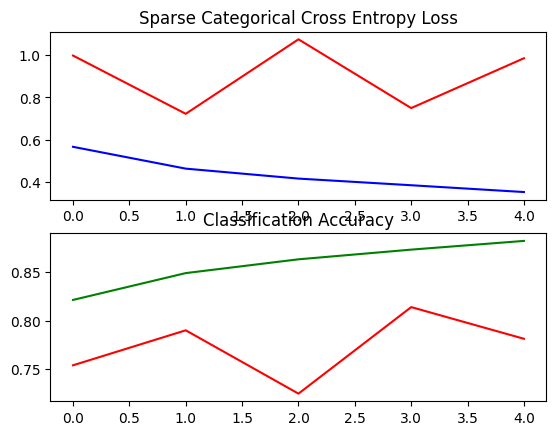

In [46]:
plt.subplot(211)
plt.title('Sparse Categorical Cross Entropy Loss')
plt.plot(history_1.history['loss'], color='blue', label='train')
plt.plot(history_1.history['val_loss'], color='red', label='val')

# plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history_1.history['accuracy'], color='green', label='train')
plt.plot(history_1.history['val_accuracy'], color='red', label='val')
plt.show()

### Evaluate the model

In [48]:
test_loss, test_acc = model_1.evaluate(test_ds, verbose=1)
print('Test loss => ', test_loss)
print('Test accuracy => ', test_acc)

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.7943 - loss: 0.7267
Test loss =>  0.7228524684906006
Test accuracy =>  0.7898356914520264


### Test the predictions

In [49]:
import numpy as np
predictions = model_1.predict(test_ds)

print(predictions.shape)
predictions = np.argmax(predictions, axis=1)

21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step
(2617, 10)


### Print confusion matrix

In [50]:
from sklearn.metrics import confusion_matrix

# Extract ground truth labels from the test dataset
gt = []
for _, labels_batch in test_ds:
    gt.extend(labels_batch.numpy())

gt = np.array(gt)  # Convert gt to a NumPy array

# Calculate and print the confusion matrix
cm = confusion_matrix(gt, predictions)
print(cm)

[[406  44   0   9   5  12   1   3  11   1]
 [  3 240   0   5   2   1   0   2   0   0]
 [  8  39 101   4   4   5   0   4   2   0]
 [  2   1   0 216   1   0   0   0   9   0]
 [  7   6   0   8 248   4   0   0   6   0]
 [ 22   3   0   3   0 131   0   1   3   0]
 [ 15  82   0   1   4   2  60  22   1   0]
 [  9  14   1   4   3   9   0 127   3   0]
 [  7   7   0  49   7   4   0   4 410   1]
 [  7   9   0  10  12  12   0   2   8 128]]


Save the model

In [51]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [60]:
model_1.save("/content/drive/MyDrive/CNN_Image_classification/m1_Mo.keras")